# Deep Learning Model: CNN - Reduced Classes
## Business Problem
Leukemia is a type of cancer of the blood that often affects young people. In the past, pathologists would diagnose patients by eye after examining blood smear images under the microscope. But, this is time consuming and tedious. Advances in image recognition technology have come a long ways since their inception. Therefore, automated solutions using computers would be of great benefit to the medical community to aid in cancer diagnoses.

The goal of this project is to address the following question: How can the doctor’s at the Munich University Hospital automate the diagnosis of patients with leukemia using images from blood smears?

## Approach
This notebook will use the previously built model, but only a subset of the training data the includes just a binary class. From this data, I will be able to assess whether this model has difficulty with the large class imbalance between all 15 classes.

In [1]:
import sys
sys.path.append('..')
from time import time

from keras import layers
from keras import metrics
from keras import models
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

from src.data_setup import make_dataset as md
from src.modeling import evaluate_model as em

%matplotlib inline

## Load Data
Load the pickled training and test data.

In [2]:
X_train, X_test, y_train, y_test = md.load_train_test('gray_rescale12_binary')

In [3]:
X_train.shape

(13982, 2304)

In [4]:
pd.Series(y_train).value_counts()

not NGS    7195
NGS        6787
dtype: int64

In [5]:
pd.Series(y_test).value_counts()

not NGS    1799
NGS        1697
dtype: int64

## Data Preparation
### Unflatten
Unflatten the feature arrays, converting them back into arrays of 2-dimensional images.

In [6]:
def unflatten(X):
    dimension = int(np.sqrt(X.shape[1]))
    return X.reshape((len(X), dimension, dimension, 1))

In [7]:
X_train_unflatten = unflatten(X_train)
X_train_unflatten.shape

(13982, 48, 48, 1)

In [8]:
X_test_unflatten = unflatten(X_test)
X_test_unflatten.shape

(3496, 48, 48, 1)

### Normalize
Normalize the features, to values between 0 and 1.

In [9]:
print(f'The maximum value for the training set is {X_train_unflatten.max()}.')
print(f'The maximum value for the test set is {X_test_unflatten.max()}.')

The maximum value for the training set is 255.
The maximum value for the test set is 255.


In [10]:
X_train_normalized = X_train_unflatten / X_train_unflatten.max()
X_test_normalized = X_test_unflatten / X_test_unflatten.max()

In [11]:
print(f'The maximum value for the normalized training set is {X_train_normalized.max()}.')
print(f'The maximum value for the normalized test set is {X_test_normalized.max()}.')

The maximum value for the normalized training set is 1.0.
The maximum value for the normalized test set is 1.0.


### Categories
First, encode the labels to integer values.

In [12]:
label_encodings = {value: i for i, value in enumerate(np.unique(y_train))}

In [13]:
label_encodings

{'NGS': 0, 'not NGS': 1}

In [14]:
pd.Series(y_train).value_counts()

not NGS    7195
NGS        6787
dtype: int64

In [15]:
y_train_encoded = pd.Series(y_train).replace(label_encodings).values
y_test_encoded = pd.Series(y_test).replace(label_encodings).values

In [16]:
np.unique(y_train_encoded)

array([0, 1])

In [17]:
np.unique(y_test_encoded)

array([0, 1])

Second, encode the integer labels as one-hot vectors.

In [18]:
y_train_one_hot = to_categorical(y_train_encoded)
y_test_one_hot = to_categorical(y_test_encoded)

In [19]:
y_train_one_hot.shape

(13982, 2)

In [20]:
y_train_one_hot[0:5, :]

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [21]:
y_test_one_hot.shape

(3496, 2)

In [22]:
y_test_one_hot[0:5, :]

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

## Validation Set
Now that we have preprocessed the training data, I will create a validation set. This will be used to evaluate how the deep learning model is training.

In [23]:
X_train_normalized, X_val, y_train_one_hot, y_val = train_test_split(X_train_normalized, y_train_one_hot, test_size=0.1, random_state=42)

## Define Model

In [24]:
input_shape = X_train_unflatten.shape[1:]
print(f'The input shape is {input_shape}.')

The input shape is (48, 48, 1).


Note: I will make one modification to the original model. Since I am only dealing with two classes, I will reduce the number of neorons in the last layer from 15 to 2.

In [25]:
model_2a = models.Sequential([
    layers.Conv2D(8, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape),
    layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    layers.Conv2D(16, kernel_size=(7, 7), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    layers.Flatten(),
    layers.Dense(600, activation='relu'),
    layers.Dense(150, activation='relu'),
    layers.Dense(38, activation='relu'),
    layers.Dense(2, activation='softmax')
])

In [26]:
model_2a.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 8)         80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 18, 18, 16)        6288      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 9, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1296)              0         
_________________________________________________________________
dense (Dense)                (None, 600)               778200    
_________________________________________________________________
dense_1 (Dense)              (None, 150)               9

### Train Model

In [27]:
model_2a.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=[
                  metrics.Accuracy(),
                  metrics.categorical_accuracy,
                  metrics.Precision(),
                  metrics.Recall()
              ])
results_3 = model_2a.fit(X_train_normalized, y_train_one_hot, validation_data=(X_val, y_val), epochs=50, batch_size=64)

Epoch 1/50
197/197 [==============================] - 9s 40ms/step - loss: 0.4579 - accuracy: 0.0000e+00 - categorical_accuracy: 0.7704 - precision: 0.7704 - recall: 0.7704 - val_loss: 0.1039 - val_accuracy: 3.5740e-04 - val_categorical_accuracy: 0.9578 - val_precision: 0.9578 - val_recall: 0.9578
Epoch 2/50
197/197 [==============================] - 7s 36ms/step - loss: 0.1140 - accuracy: 0.0011 - categorical_accuracy: 0.9616 - precision: 0.9616 - recall: 0.9616 - val_loss: 0.0756 - val_accuracy: 7.1480e-04 - val_categorical_accuracy: 0.9707 - val_precision: 0.9707 - val_recall: 0.9707
Epoch 3/50
197/197 [==============================] - 7s 37ms/step - loss: 0.0820 - accuracy: 0.0023 - categorical_accuracy: 0.9735 - precision: 0.9735 - recall: 0.9735 - val_loss: 0.0817 - val_accuracy: 0.0311 - val_categorical_accuracy: 0.9757 - val_precision: 0.9757 - val_recall: 0.9757
Epoch 4/50
197/197 [==============================] - 7s 37ms/step - loss: 0.0675 - accuracy: 0.0192 - categorical_

#### Predictions
Make class predictions using the model.

In [28]:
y_pred_cnn = model_2a.predict(X_test_normalized)

### Evaluate the Model

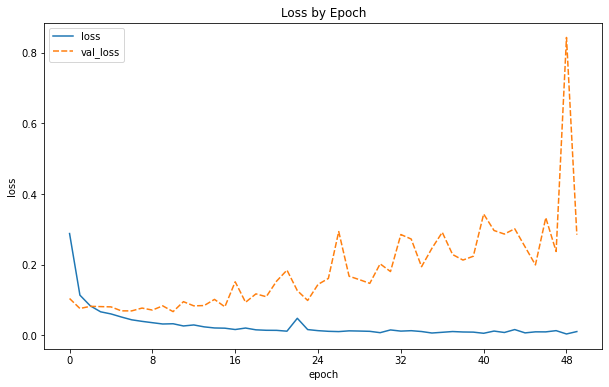

In [29]:
em.plot_train_val_losses(results_3, figure_name='losses_model_2a')

**Observations:**
The flat curve for the training loss indicates that this model is underfitting. It is not complex enough.

In [30]:
print(classification_report(np.argmax(y_test_one_hot, axis=1), np.argmax(y_pred_cnn, axis=1)))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1697
           1       0.98      0.97      0.98      1799

    accuracy                           0.98      3496
   macro avg       0.98      0.98      0.98      3496
weighted avg       0.98      0.98      0.98      3496



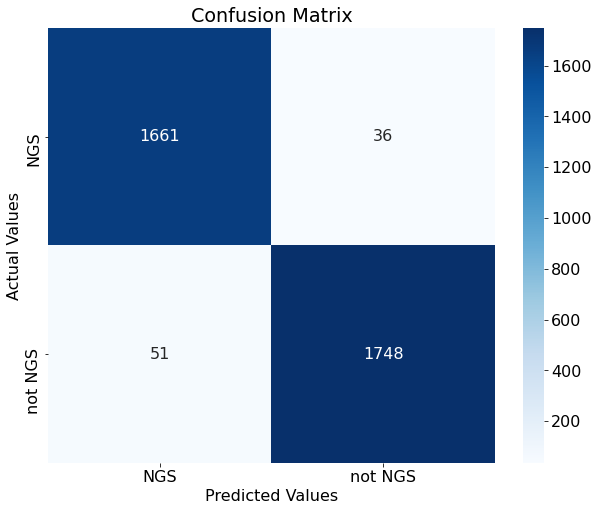

In [31]:
em.plot_confusion_matrix(y_test_one_hot, y_pred_cnn, label_encodings, figure_name='cm_model_2a')

**Observations:**
Despite not training well, the model does a pretty good job at making predictions.

### Train Model - Use Weighted Classes
In the previous CNN model, I also tried weighting the classes to counter class imbalance. While these two classes are more balanced, they are not equal. Therefore, in order to be complete, I will also try weighting the classes and see how the model performs.

In [32]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_encoded), y=y_train_encoded)
class_weights_dict = dict(enumerate(class_weights))

In [33]:
class_weights_dict

{0: 1.0300574627965227, 1: 0.9716469770674079}

In [34]:
model_2b = models.Sequential([
    layers.Conv2D(8, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape),
    layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    layers.Conv2D(16, kernel_size=(7, 7), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    layers.Flatten(),
    layers.Dense(600, activation='relu'),
    layers.Dense(150, activation='relu'),
    layers.Dense(38, activation='relu'),
    layers.Dense(2, activation='softmax')
])

In [35]:
model_2b.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=[
                    metrics.Accuracy(),
                    metrics.categorical_accuracy,
                    metrics.Precision(),
                    metrics.Recall()
                ])
results_4 = model_2b.fit(X_train_normalized, y_train_one_hot, validation_data=(X_val, y_val), epochs=50, batch_size=64, class_weight=class_weights_dict)

Epoch 1/50
197/197 [==============================] - 8s 36ms/step - loss: 0.4910 - accuracy: 0.0000e+00 - categorical_accuracy: 0.7498 - precision_1: 0.7498 - recall_1: 0.7498 - val_loss: 0.2167 - val_accuracy: 0.0000e+00 - val_categorical_accuracy: 0.9092 - val_precision_1: 0.9092 - val_recall_1: 0.9092
Epoch 2/50
197/197 [==============================] - 7s 35ms/step - loss: 0.1442 - accuracy: 6.5163e-04 - categorical_accuracy: 0.9484 - precision_1: 0.9484 - recall_1: 0.9484 - val_loss: 0.1129 - val_accuracy: 0.0050 - val_categorical_accuracy: 0.9628 - val_precision_1: 0.9628 - val_recall_1: 0.9628
Epoch 3/50
197/197 [==============================] - 7s 37ms/step - loss: 0.1066 - accuracy: 0.0026 - categorical_accuracy: 0.9635 - precision_1: 0.9635 - recall_1: 0.9635 - val_loss: 0.0941 - val_accuracy: 0.0011 - val_categorical_accuracy: 0.9635 - val_precision_1: 0.9635 - val_recall_1: 0.9635
Epoch 4/50
197/197 [==============================] - 7s 36ms/step - loss: 0.0908 - accurac

In [36]:
results_4.history.keys()

dict_keys(['loss', 'accuracy', 'categorical_accuracy', 'precision_1', 'recall_1', 'val_loss', 'val_accuracy', 'val_categorical_accuracy', 'val_precision_1', 'val_recall_1'])

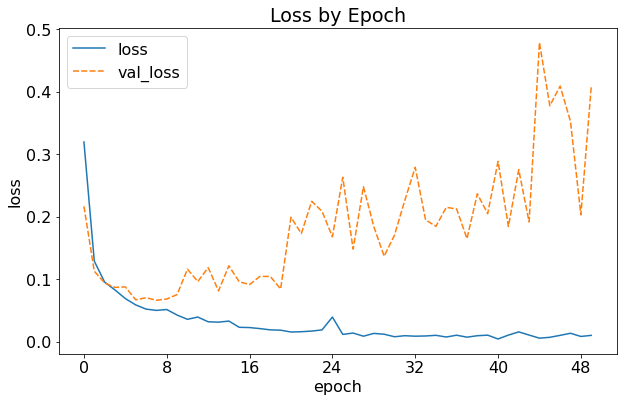

In [37]:
em.plot_train_val_losses(results_4, figure_name='losses_model_2b')

### Predictions
Make class predictions using the model fit using weighted classes.

In [38]:
y_pred_cnn_2 = model_2b.predict(X_test_normalized)

In [39]:
print(classification_report(np.argmax(y_test_one_hot, axis=1), np.argmax(y_pred_cnn_2, axis=1)))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97      1697
           1       0.95      0.99      0.97      1799

    accuracy                           0.97      3496
   macro avg       0.97      0.97      0.97      3496
weighted avg       0.97      0.97      0.97      3496



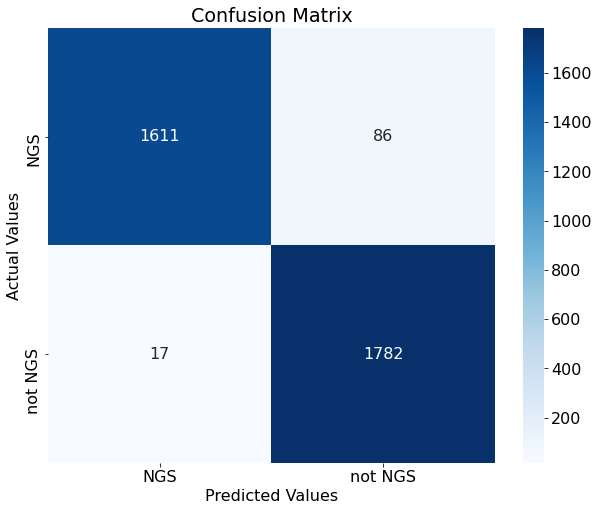

In [40]:
em.plot_confusion_matrix(y_test_one_hot, y_pred_cnn_2, label_encodings, figure_name='cm_model_2b')

**Observations:** The flat curve still indicates that the model is underfitting.

## Summary
After fitting the CNN to a dataset with only two classes, I have determined that the model is underfitting. Nevertheless, it has high predictive power, as shown by the classification report for the test set and the confussion matrix.

## Future Direction
Since this model is underfitting, even for a two class problem, this indicates that I need a more complicated model in order to be able to learn useful features that can be used to predict leukocite class. 

As future work, I will extend my project to include the following improvements:
* Develop more complex architecture.
* Explore data augmentation to counter class imbalance.